# Superconducting Qubits

These examples all cover dynamical simulation of superconducting qubits. These examples use small systems, but note that the GPU will only provide an advantage for systems with total dimension of O(1000). 

## Cavity QED
This example demonstrates a simulation of cavity quantum electrodynamics (interaction between light confined in a reflective cavity and atoms)

Text(0.5, 1.0, 'With decay')

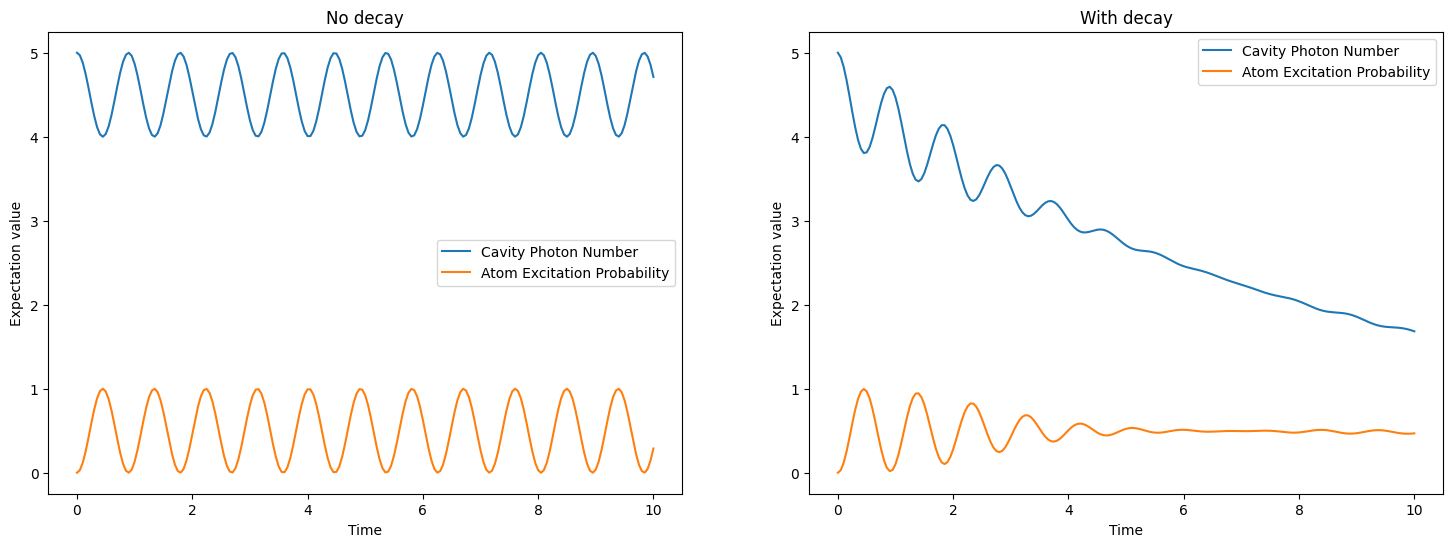

In [3]:
import cudaq
from cudaq import boson, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# System dimensions: atom (2-level system) and cavity (10-level system)
dimensions = {0: 2, 1: 10}

# Alias for commonly used operators
# Cavity operators
a = boson.annihilate(1)
a_dag = boson.create(1)

# Atom operators
sm = boson.annihilate(0)
sm_dag = boson.create(0)

# Defining the Hamiltonian for the system: self-energy terms and cavity-atom interaction term.
# This is the so-called Jaynes-Cummings model:
# https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model
hamiltonian = 2 * np.pi * boson.number(1) + 2 * np.pi * boson.number(
    0) + 2 * np.pi * 0.25 * (sm * a_dag + sm_dag * a)

# Initial state of the system
# Atom in ground state
qubit_state = cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128)

# Cavity in a state which has 5 photons initially
cavity_state = cp.zeros((10, 10), dtype=cp.complex128)
cavity_state[5][5] = 1.0
rho0 = cudaq.State.from_data(cp.kron(qubit_state, cavity_state))

steps = np.linspace(0, 10, 201)
schedule = Schedule(steps, ["time"])

# First, evolve the system without any collapse operators (ideal).
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                rho0,
                                observables=[boson.number(1),
                                             boson.number(0)],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())

# Then, evolve the system with a collapse operator modeling cavity decay (leaking photons)
evolution_result_decay = cudaq.evolve(
    hamiltonian,
    dimensions,
    schedule,
    rho0,
    observables=[boson.number(1), boson.number(0)],
    collapse_operators=[np.sqrt(0.1) * a],
    store_intermediate_results=True,
    integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
ideal_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result)
]
decay_results = [
    get_result(0, evolution_result_decay),
    get_result(1, evolution_result_decay)
]

fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, ideal_results[0])
plt.plot(steps, ideal_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Cavity Photon Number", "Atom Excitation Probability"))
plt.title("No decay")

plt.subplot(1, 2, 2)
plt.plot(steps, decay_results[0])
plt.plot(steps, decay_results[1])
plt.ylabel("Expectation value")
plt.xlabel("Time")
plt.legend(("Cavity Photon Number", "Atom Excitation Probability"))
plt.title("With decay")

## Cross Resonance

This example simulates cross-resonance interactions between superconducting qubits. Cross-resonance interaction is key to implementing two-qubit conditional gates, e.g., the CNOT gate. The example comes from a [simple all-microwave entangling gate for fixed-frequency superconducting qubits](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.107.080502).

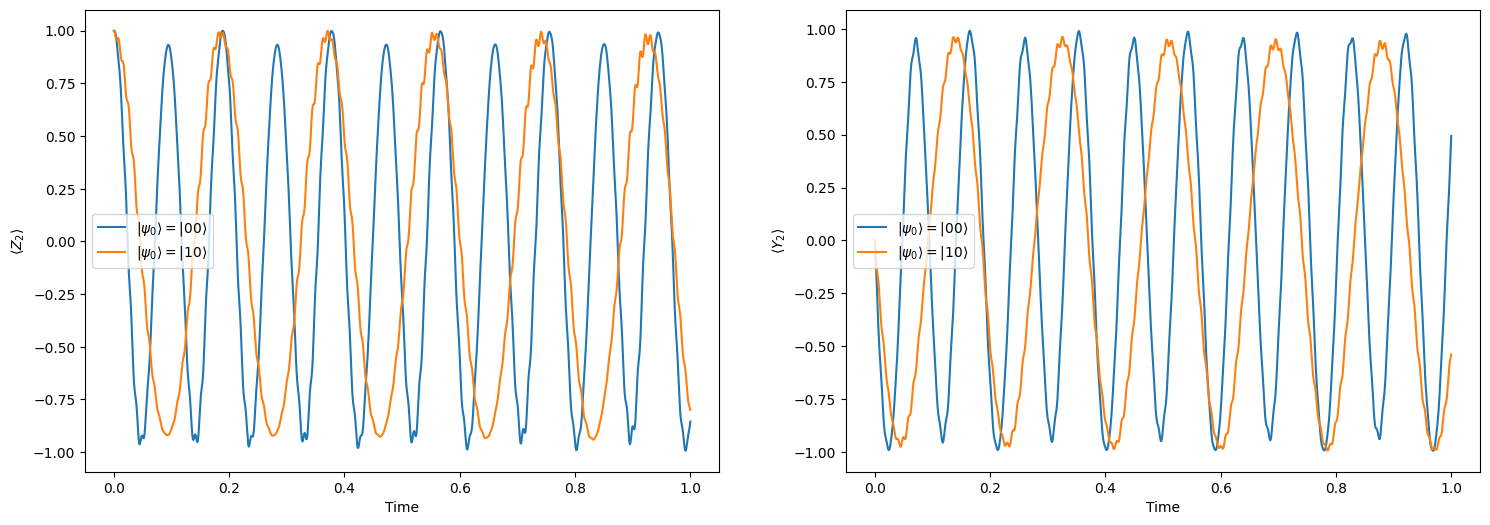

In [2]:
import cudaq
from cudaq import spin, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Device parameters
# Detuning between two qubits
delta = 100 * 2 * np.pi
# Static coupling between qubits
J = 7 * 2 * np.pi
# spurious electromagnetic `crosstalk` due to stray electromagnetic coupling in the device circuit and package
# see (Physical Review Letters 107, 080502)
m_12 = 0.2
# Drive strength
Omega = 20 * 2 * np.pi

# Qubit Hamiltonian (in the rotating frame w.r.t. the target qubit)
hamiltonian = delta / 2 * spin.z(0) + J * (
    spin.minus(1) * spin.plus(0) +
    spin.plus(1) * spin.minus(0)) + Omega * spin.x(0) + m_12 * Omega * spin.x(1)

# Dimensions of sub-system
dimensions = {0: 2, 1: 2}

# Initial state of the system (ground state).
rho0 = cudaq.State.from_data(
    cp.array([[1.0, 0.0], [0.0, 0.0]], dtype=cp.complex128))

# Two initial states: |00> and |10>.
# We show the 'conditional' evolution when controlled qubit is in |1> state.
psi_00 = cudaq.State.from_data(
    cp.array([1.0, 0.0, 0.0, 0.0], dtype=cp.complex128))
psi_10 = cudaq.State.from_data(
    cp.array([0.0, 0.0, 1.0, 0.0], dtype=cp.complex128))

# Schedule of time steps.
steps = np.linspace(0.0, 1.0, 1001)
schedule = Schedule(steps, ["time"])

# Run the simulation.
# Control bit = 0
evolution_result_00 = cudaq.evolve(hamiltonian,
                                   dimensions,
                                   schedule,
                                   psi_00,
                                   observables=[
                                       spin.x(0),
                                       spin.y(0),
                                       spin.z(0),
                                       spin.x(1),
                                       spin.y(1),
                                       spin.z(1)
                                   ],
                                   collapse_operators=[],
                                   store_intermediate_results=True,
                                   integrator=ScipyZvodeIntegrator())

# Control bit = 1
evolution_result_10 = cudaq.evolve(hamiltonian,
                                   dimensions,
                                   schedule,
                                   psi_10,
                                   observables=[
                                       spin.x(0),
                                       spin.y(0),
                                       spin.z(0),
                                       spin.x(1),
                                       spin.y(1),
                                       spin.z(1)
                                   ],
                                   collapse_operators=[],
                                   store_intermediate_results=True,
                                   integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
results_00 = [
    get_result(0, evolution_result_00),
    get_result(1, evolution_result_00),
    get_result(2, evolution_result_00),
    get_result(3, evolution_result_00),
    get_result(4, evolution_result_00),
    get_result(5, evolution_result_00)
]
results_10 = [
    get_result(0, evolution_result_10),
    get_result(1, evolution_result_10),
    get_result(2, evolution_result_10),
    get_result(3, evolution_result_10),
    get_result(4, evolution_result_10),
    get_result(5, evolution_result_10)
]

# The changes in recession frequencies of the target qubit when control qubit is in |1> state allow us to implement two-qubit conditional gates.
fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, results_00[5])
plt.plot(steps, results_10[5])
plt.ylabel(r"$\langle Z_2\rangle$")
plt.xlabel("Time")
plt.legend((r"$|\psi_0\rangle=|00\rangle$", r"$|\psi_0\rangle=|10\rangle$"))

plt.subplot(1, 2, 2)
plt.plot(steps, results_00[4])
plt.plot(steps, results_10[4])
plt.ylabel(r"$\langle Y_2\rangle$")
plt.xlabel("Time")
plt.legend((r"$|\psi_0\rangle=|00\rangle$", r"$|\psi_0\rangle=|10\rangle$"))

## Transmon Resonator

This example demonstrates a simulation of a superconducting transmon qubit coupled to a resonator (i.e., cavity). Based on refs from "[Charge-insensitive qubit design derived from the Cooper pair box](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.76.042319)" and [https://github.com/jrjohansson/qutip-lectures/blob/master/Lecture-10-cQED-dispersive-regime.ipynb](https://github.com/jrjohansson/qutip-lectures/blob/master/Lecture-10-cQED-dispersive-regime.ipynb)

Text(0.5, 1.0, 'Resonator Quadrature')

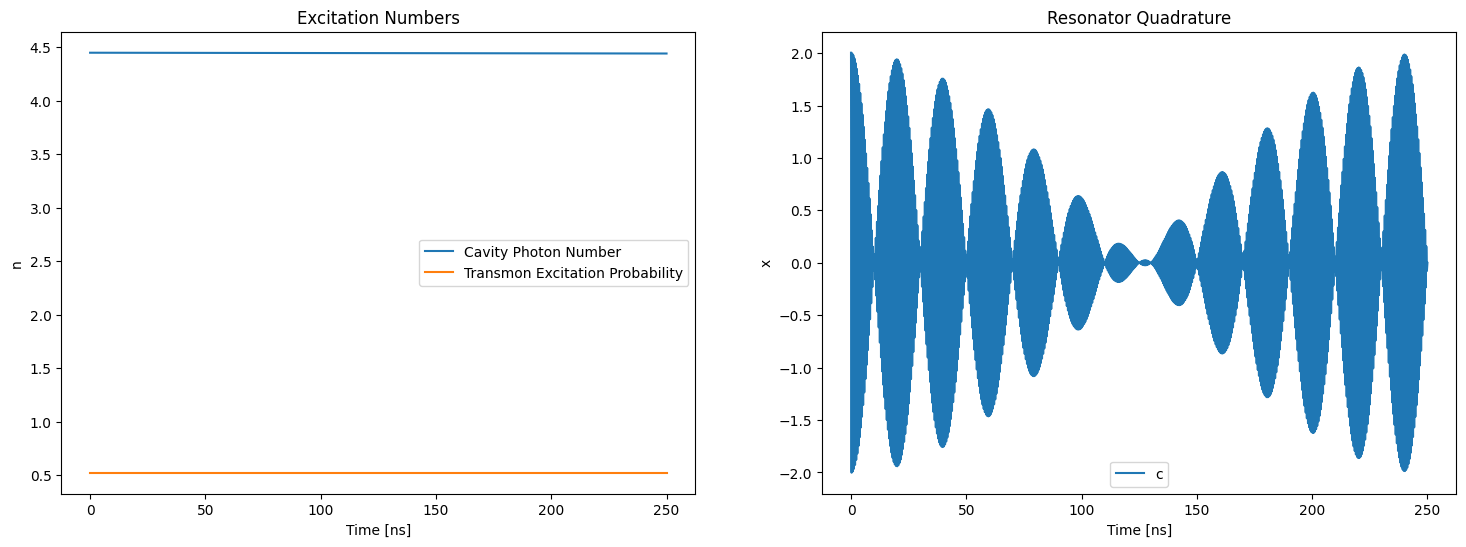

In [1]:
import cudaq
from cudaq import operators, spin, operators, Schedule, ScipyZvodeIntegrator
import numpy as np
import cupy as cp
import os
import matplotlib.pyplot as plt

# Set the target to our dynamics simulator
cudaq.set_target("dynamics")

# Number of cavity photons
N = 20

# System dimensions: transmon + cavity
dimensions = {0: 2, 1: N}

# See III.B of PRA 76, 042319
# System parameters
# Unit: GHz
omega_01 = 3.0 * 2 * np.pi  # transmon qubit frequency
omega_r = 2.0 * 2 * np.pi  # resonator frequency
# Dispersive shift
chi_01 = 0.025 * 2 * np.pi
chi_12 = 0.0

omega_01_prime = omega_01 + chi_01
omega_r_prime = omega_r - chi_12 / 2.0
chi = chi_01 - chi_12 / 2.0

# System Hamiltonian
hamiltonian = 0.5 * omega_01_prime * spin.z(0) + (
    omega_r_prime + chi * spin.z(0)) * operators.number(1)

# Initial state of the system
# Transmon in a superposition state
transmon_state = cp.array([1. / np.sqrt(2.), 1. / np.sqrt(2.)],
                          dtype=cp.complex128)


# Helper to create a coherent state in Fock basis truncated at `num_levels`.
# Note: There are a couple of ways of generating a coherent state,
# e.g., see https://qutip.readthedocs.io/en/v5.0.3/apidoc/functions.html#qutip.core.states.coherent
# or https://en.wikipedia.org/wiki/Coherent_state
# Here, in this example, we use a the formula: `|alpha> = D(alpha)|0>`,
# i.e., apply the displacement operator on a zero (or vacuum) state to compute the corresponding coherent state.
def coherent_state(num_levels, amplitude):
    displace_mat = operators.displace(0).to_matrix({0: num_levels},
                                                   displacement=amplitude)
    # `D(alpha)|0>` is the first column of `D(alpha)` matrix
    return cp.array(np.transpose(displace_mat)[0])


# Cavity in a coherent state
cavity_state = coherent_state(N, 2.0)
psi0 = cudaq.State.from_data(cp.kron(transmon_state, cavity_state))

steps = np.linspace(0, 250, 1000)
schedule = Schedule(steps, ["time"])

# Evolve the system
evolution_result = cudaq.evolve(hamiltonian,
                                dimensions,
                                schedule,
                                psi0,
                                observables=[
                                    operators.number(1),
                                    operators.number(0),
                                    operators.position(1),
                                    operators.position(0)
                                ],
                                collapse_operators=[],
                                store_intermediate_results=True,
                                integrator=ScipyZvodeIntegrator())

get_result = lambda idx, res: [
    exp_vals[idx].expectation() for exp_vals in res.expectation_values()
]
count_results = [
    get_result(0, evolution_result),
    get_result(1, evolution_result)
]

quadrature_results = [
    get_result(2, evolution_result),
    get_result(3, evolution_result)
]

fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(steps, count_results[0])
plt.plot(steps, count_results[1])
plt.ylabel("n")
plt.xlabel("Time [ns]")
plt.legend(("Cavity Photon Number", "Transmon Excitation Probability"))
plt.title("Excitation Numbers")

plt.subplot(1, 2, 2)
plt.plot(steps, quadrature_results[0])
plt.ylabel("x")
plt.xlabel("Time [ns]")
plt.legend(("cavity"))
plt.title("Resonator Quadrature")